In [1]:
# google-drive-ocamlfuseのインストール
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Colab用のAuth token作成
from google.colab import auth
auth.authenticate_user()

# Drive FUSE library用のcredential生成
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# drive/ を作り、そこにGoogle Driveをマウントする
!mkdir -p drive
!google-drive-ocamlfuse drive

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


# データの読み込み関連

データ数が多いのでargumentationはしない

In [0]:
import numpy as np
from PIL import Image
from PIL import ImageOps
from xml.etree.ElementTree import *
import math
import random

def get_distance(a, b):
  dx = b[0] - a[0]
  dy = b[1] - a[1]
  return math.sqrt(dx * dx + dy * dy)

def get_center(a, b):
  dx = b[0] - a[0]
  dy = b[1] - a[1]
  return [a[0] + dx / 2, a[1] + dy / 2]

def get_box_from_center_and_length(c, l):
  return (c[0] - l, c[1] - l, c[0] + l, c[1] + l)

def read_image_data(xmlfile, data):
  # 読み込み
  tree = parse(xmlfile)
  root = tree.getroot()
  images = root.find("images")
  
  i = 0
  for image in list(images):
#     print("drive/" + image.get("file"))
    if i % 4 != 0:
      i += 1
      continue
    img = Image.open("drive/" + image.get("file")).convert('L')
    for box in list(image):
      parts = {}
      for part in list(box):
        parts[part.get("name")] = [int(part.get("x")), int(part.get("y")), 1]
      
      c = get_center(parts["144"], parts["124"])
      l = get_distance(c, parts["18"])
      cropped = np.array(img.crop(get_box_from_center_and_length(c, l)).resize((100, 100)), dtype=np.float32) / 256.0
#       print(cropped.shape)
#       cropped = np.reshape(cropped, (100, 100))
      
      for part in parts.values():
        part[0] -= c[0] - l
        part[1] -= c[1] - l
      
      data.append({'img': cropped, 'parts': parts})
    i += 1
    
 

# ネットワークの定義

In [3]:
!pip2 install pydot
!pip3 install pydot
!apt install graphviz
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D
from keras.layers.core import Dense, Activation, Dropout, Flatten, Reshape
from keras.utils import plot_model
from keras.callbacks import TensorBoard
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf

imgsize = 100
landmark = 194

old_session = KTF.get_session()

session = tf.Session('')
KTF.set_session(session)
KTF.set_learning_phase(1)

model = Sequential()
model.add(Conv2D(16, 4, input_shape=(100, 100, 1)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, 5, input_shape=(48, 48, 16)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, 5, input_shape=(22, 22, 32)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(400, activation='relu'))
model.add(Dense(landmark * 2))

plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

    100% |████████████████████████████████| 133kB 3.5MB/s 
  Running setup.py bdist_wheel for pydot ... - done
  Stored in directory: /content/.cache/pip/wheels/6a/a5/14/25541ebcdeaf97a37b6d05c7ff15f5bd20f5e91b99d313e5b4
Successfully built pydot
  Cache entry deserialization failed, entry ignored
  Using cached https://files.pythonhosted.org/packages/c3/f1/e61d6dfe6c1768ed2529761a68f70939e2569da043e9f15a8d84bf56cadf/pydot-1.2.4.tar.gz
  Running setup.py bdist_wheel for pydot ... - done
  Stored in directory: /content/.cache/pip/wheels/6a/a5/14/25541ebcdeaf97a37b6d05c7ff15f5bd20f5e91b99d313e5b4
Successfully built pydot
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3 libgraphite2-3
  libgvc6 libgvpr2 libharfbuzz0b libjbig0 libltdl7 libpango-1.0-0
  libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4 libpixman-1-0
  libthai-dat

7Progress: [  3%] [##........................................................] 87Progress: [  4%] [##........................................................] 8Selecting previously unselected package libcdt5.
Preparing to unpack .../02-libcdt5_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libcdt5 (2.38.0-16ubuntu2) ...
7Progress: [  5%] [###.......................................................] 87Progress: [  6%] [###.......................................................] 8Selecting previously unselected package libcgraph6.
Preparing to unpack .../03-libcgraph6_2.38.0-16ubuntu2_amd64.deb ...
7Progress: [  7%] [####......................................................] 8Unpacking libcgraph6 (2.38.0-16ubuntu2) ...
7Progress: [  8%] [####......................................................] 8Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../04-libtiff5_4.0.8-5ubuntu0.1_amd64.deb ...
7Progress: [  9%] [#####.......................................

Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../18-libharfbuzz0b_1.4.2-1_amd64.deb ...
7Progress: [ 39%] [######################....................................] 8Unpacking libharfbuzz0b:amd64 (1.4.2-1) ...
7Progress: [ 40%] [#######################...................................] 8Selecting previously unselected package libpangoft2-1.0-0:amd64.
Preparing to unpack .../19-libpangoft2-1.0-0_1.40.12-1_amd64.deb ...
7Progress: [ 41%] [#######################...................................] 8Unpacking libpangoft2-1.0-0:amd64 (1.40.12-1) ...
7Progress: [ 42%] [########################..................................] 8Selecting previously unselected package libpangocairo-1.0-0:amd64.
Preparing to unpack .../20-libpangocairo-1.0-0_1.40.12-1_amd64.deb ...
7Progress: [ 43%] [#########################.................................] 8Unpacking libpangocairo-1.0-0:amd64 (1.40.12-1) ...
7Progress: [ 44%] [#########################...

Setting up libgvpr2 (2.38.0-16ubuntu2) ...
7Progress: [ 84%] [################################################..........] 87Progress: [ 85%] [#################################################.........] 8Setting up libgd3:amd64 (2.2.5-3) ...
7Progress: [ 86%] [##################################################........] 8Setting up libharfbuzz0b:amd64 (1.4.2-1) ...
7Progress: [ 87%] [##################################################........] 8Setting up libthai0:amd64 (0.1.26-3) ...
7Progress: [ 88%] [###################################################.......] 87Progress: [ 89%] [###################################################.......] 8Setting up libxmu6:amd64 (2:1.1.2-2) ...
7Progress: [ 90%] [####################################################......] 8Setting up libpango-1.0-0:amd64 (1.40.12-1) ...
7Progress: [ 91%] [#####################################################.....] 87Progress: [ 92%] [#####################################################.....] 8Settin

Using TensorFlow backend.


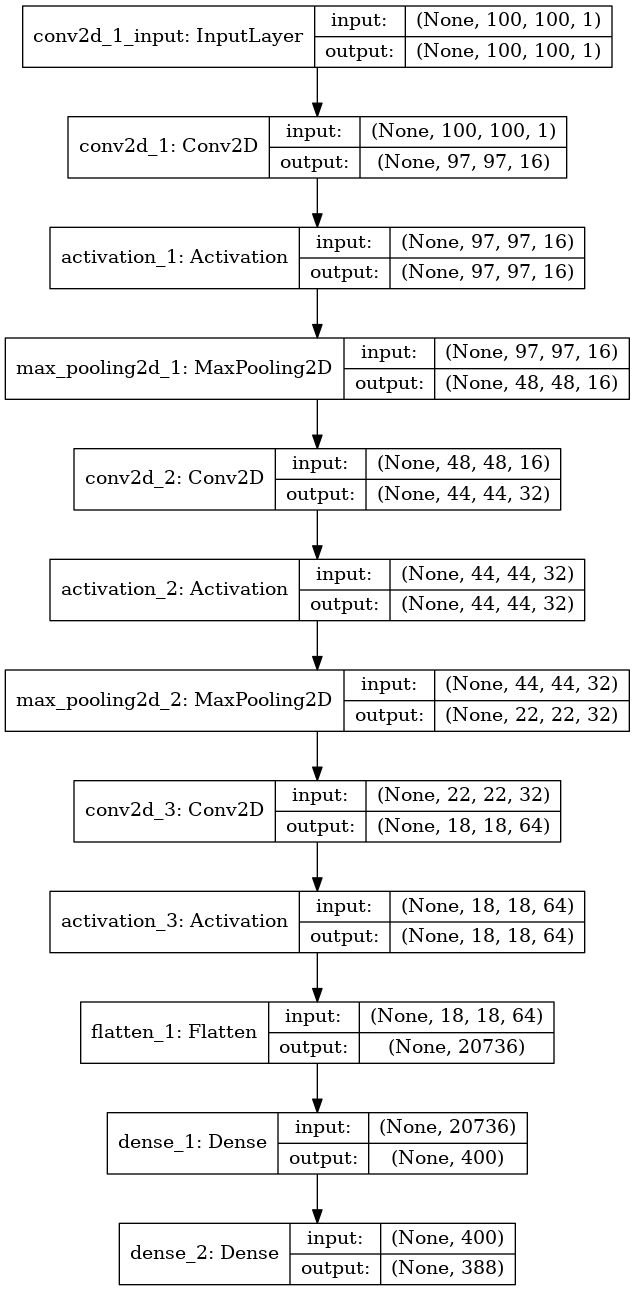

In [4]:
Image.open('model.png')

# 実際の学習

In [0]:
# from keras.models import load_model
# model = load_model("drive/model.hdf5")

In [0]:
train_data = []
read_image_data('drive/train.xml', train_data)
test_data = []
read_image_data('drive/test.xml', test_data)

In [6]:
def parts_to_array(parts):
  c = get_center(parts["144"], parts["124"])
  l = get_distance(c, parts["18"])
  x1, y1, x2, y2 = get_box_from_center_and_length(c, l)
  arr = []
  for i in range(194):
    name = ""
    if i < 100:
      name = "{:02}".format(i)
    else:
      name = "{}".format(i)
    x = (parts[name][0] - x1) / (x2 - x1)
    y = (parts[name][0] - y1) / (y2 - y1)
    arr.append([x, y])
  return np.array(arr, dtype=np.float32)
x = []
t = []
for train in train_data:
  x.append(train['img'])
  t.append(parts_to_array(train['parts']))
x = np.array(x)
t = np.array(t)
print(t.shape)
x = np.reshape(x, (500, imgsize, imgsize, 1))
t = np.reshape(t, (500, landmark*2))
x_t = []
t_t = []
for test in test_data:
  x_t.append(test['img'])
  t_t.append(parts_to_array(test['parts']))
x_t = np.reshape(x_t, (330/4+1, imgsize, imgsize, 1))
t_t = np.reshape(t_t, (330/4+1, landmark*2))

(500, 194, 2)


In [7]:
from keras.optimizers import Adam, RMSprop
from keras import losses
from keras.callbacks import ModelCheckpoint

check = ModelCheckpoint("drive/model.hdf5")
tb_cb = TensorBoard(log_dir="drive/tflog/", histogram_freq=1)

model.compile(loss=losses.mean_squared_error,
              optimizer=RMSprop(),
              metrics=['accuracy'])
history = model.fit(x, t,
          batch_size=20, epochs=1000, validation_split=0.2,
          callbacks=[check, tb_cb])
loss, accuracy = model.evaluate(x_t, t_t)
print("\nloss:{} accuracy:{}".format(loss, accuracy))

KTF.set_session(old_session)

Train on 400 samples, validate on 100 samples
Epoch 1/1000
400/400 [==============================] - 2s 4ms/step - loss: 0.2200 - acc: 0.0600 - val_loss: 0.0186 - val_acc: 0.2700
Epoch 2/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0221 - acc: 0.1500 - val_loss: 0.0249 - val_acc: 0.2500
Epoch 3/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0296 - acc: 0.0800 - val_loss: 0.0291 - val_acc: 0.0500
Epoch 4/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0254 - acc: 0.0800 - val_loss: 0.0205 - val_acc: 0.1000
Epoch 5/1000
400/400 [==============================] - 1s 2ms/step - loss: 0.0194 - acc: 0.0975 - val_loss: 0.0107 - val_acc: 0.0200
Epoch 6/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0134 - acc: 0.1125 - val_loss: 0.0153 - val_acc: 0.0500
Epoch 7/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0119 - acc: 0.1475 - val_loss: 0.0081 - val_acc: 0.0900
Epoch 8/1000
400

400/400 [==============================] - 1s 1ms/step - loss: 0.0053 - acc: 0.1725 - val_loss: 0.0053 - val_acc: 0.1600
Epoch 14/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0050 - acc: 0.2350 - val_loss: 0.0040 - val_acc: 0.0600
Epoch 15/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0039 - acc: 0.1425 - val_loss: 0.0063 - val_acc: 0.2100
Epoch 16/1000
400/400 [==============================] - 0s 1ms/step - loss: 0.0036 - acc: 0.1300 - val_loss: 0.0042 - val_acc: 0.0300
Epoch 17/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0055 - acc: 0.1550 - val_loss: 0.0052 - val_acc: 0.0400
Epoch 18/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0040 - acc: 0.1100 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 19/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0036 - acc: 0.1350 - val_loss: 0.0051 - val_acc: 0.1300
Epoch 20/1000
400/400 [==============================] - 1s 1ms/s

400/400 [==============================] - 1s 1ms/step - loss: 0.0032 - acc: 0.1075 - val_loss: 0.0028 - val_acc: 0.2900
Epoch 26/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0033 - acc: 0.1000 - val_loss: 0.0031 - val_acc: 0.1400
Epoch 27/1000
400/400 [==============================] - 0s 1ms/step - loss: 0.0032 - acc: 0.1050 - val_loss: 0.0039 - val_acc: 0.0900
Epoch 28/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0027 - acc: 0.1150 - val_loss: 0.0040 - val_acc: 0.2700
Epoch 29/1000
400/400 [==============================] - 1s 2ms/step - loss: 0.0028 - acc: 0.1275 - val_loss: 0.0019 - val_acc: 0.1300
Epoch 30/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0023 - acc: 0.1300 - val_loss: 0.0040 - val_acc: 0.1900
Epoch 31/1000
400/400 [==============================] - 0s 1ms/step - loss: 0.0024 - acc: 0.1250 - val_loss: 0.0030 - val_acc: 0.1700
Epoch 32/1000
400/400 [==============================] - 0s 1ms/step 

400/400 [==============================] - 1s 1ms/step - loss: 0.0021 - acc: 0.1275 - val_loss: 0.0019 - val_acc: 0.1800
Epoch 38/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0019 - acc: 0.1275 - val_loss: 0.0021 - val_acc: 0.1200
Epoch 39/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0018 - acc: 0.1275 - val_loss: 0.0017 - val_acc: 0.1700
Epoch 40/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0019 - acc: 0.1450 - val_loss: 0.0021 - val_acc: 0.1000
Epoch 41/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0018 - acc: 0.1550 - val_loss: 0.0018 - val_acc: 0.2100
Epoch 42/1000
400/400 [==============================] - 0s 1ms/step - loss: 0.0018 - acc: 0.1400 - val_loss: 0.0015 - val_acc: 0.2500
Epoch 43/1000
400/400 [==============================] - 0s 1ms/step - loss: 0.0013 - acc: 0.1575 - val_loss: 0.0014 - val_acc: 0.2800
Epoch 44/1000
400/400 [==============================] - 1s 2ms/step 

400/400 [==============================] - 1s 1ms/step - loss: 0.0012 - acc: 0.1750 - val_loss: 0.0017 - val_acc: 0.2200
Epoch 50/1000
400/400 [==============================] - 0s 1ms/step - loss: 0.0013 - acc: 0.1950 - val_loss: 0.0032 - val_acc: 0.1900
Epoch 51/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0013 - acc: 0.1875 - val_loss: 0.0011 - val_acc: 0.1600
Epoch 52/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0012 - acc: 0.2025 - val_loss: 0.0012 - val_acc: 0.2200
Epoch 53/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0012 - acc: 0.2000 - val_loss: 0.0016 - val_acc: 0.2500
Epoch 54/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0011 - acc: 0.1600 - val_loss: 0.0013 - val_acc: 0.1900
Epoch 55/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0012 - acc: 0.1900 - val_loss: 0.0034 - val_acc: 0.1800
Epoch 56/1000
400/400 [==============================] - 1s 2ms/step 

400/400 [==============================] - 1s 1ms/step - loss: 9.4812e-04 - acc: 0.1725 - val_loss: 9.9885e-04 - val_acc: 0.2200
Epoch 62/1000
400/400 [==============================] - 1s 1ms/step - loss: 0.0011 - acc: 0.2200 - val_loss: 9.0398e-04 - val_acc: 0.1700
Epoch 63/1000
400/400 [==============================] - 1s 1ms/step - loss: 8.9070e-04 - acc: 0.2050 - val_loss: 8.8363e-04 - val_acc: 0.1800
Epoch 64/1000
400/400 [==============================] - 1s 2ms/step - loss: 9.3581e-04 - acc: 0.1875 - val_loss: 0.0013 - val_acc: 0.2800
Epoch 65/1000
400/400 [==============================] - 1s 1ms/step - loss: 9.8332e-04 - acc: 0.2125 - val_loss: 8.2962e-04 - val_acc: 0.1700
Epoch 66/1000
400/400 [==============================] - 0s 1ms/step - loss: 8.2203e-04 - acc: 0.2150 - val_loss: 0.0017 - val_acc: 0.2500
Epoch 67/1000
400/400 [==============================] - 0s 1ms/step - loss: 0.0010 - acc: 0.2250 - val_loss: 9.7322e-04 - val_acc: 0.1800
Epoch 68/1000
400/400 [======

400/400 [==============================] - 1s 1ms/step - loss: 6.9859e-04 - acc: 0.2125 - val_loss: 9.0313e-04 - val_acc: 0.2000
Epoch 74/1000
400/400 [==============================] - 0s 1ms/step - loss: 8.3329e-04 - acc: 0.1900 - val_loss: 0.0015 - val_acc: 0.1900
Epoch 75/1000
400/400 [==============================] - 0s 1ms/step - loss: 6.6097e-04 - acc: 0.1975 - val_loss: 0.0011 - val_acc: 0.2400
Epoch 76/1000
400/400 [==============================] - 1s 1ms/step - loss: 8.0406e-04 - acc: 0.1850 - val_loss: 9.4923e-04 - val_acc: 0.1700
Epoch 77/1000
400/400 [==============================] - 1s 1ms/step - loss: 7.1602e-04 - acc: 0.1900 - val_loss: 9.9456e-04 - val_acc: 0.1500
Epoch 78/1000
400/400 [==============================] - 1s 1ms/step - loss: 7.2211e-04 - acc: 0.1975 - val_loss: 0.0011 - val_acc: 0.1100
Epoch 79/1000
400/400 [==============================] - 0s 1ms/step - loss: 7.0802e-04 - acc: 0.1900 - val_loss: 0.0010 - val_acc: 0.1800
Epoch 80/1000
400/400 [======

400/400 [==============================] - 1s 1ms/step - loss: 6.8597e-04 - acc: 0.1975 - val_loss: 9.4048e-04 - val_acc: 0.1900
Epoch 86/1000
400/400 [==============================] - 0s 1ms/step - loss: 6.4947e-04 - acc: 0.2300 - val_loss: 0.0016 - val_acc: 0.1900
Epoch 87/1000
400/400 [==============================] - 1s 2ms/step - loss: 7.2900e-04 - acc: 0.1875 - val_loss: 9.8387e-04 - val_acc: 0.2300
Epoch 88/1000
400/400 [==============================] - 1s 1ms/step - loss: 5.6701e-04 - acc: 0.1975 - val_loss: 0.0019 - val_acc: 0.2000
Epoch 89/1000
400/400 [==============================] - 0s 1ms/step - loss: 6.3288e-04 - acc: 0.2325 - val_loss: 0.0013 - val_acc: 0.1700
Epoch 90/1000
400/400 [==============================] - 1s 1ms/step - loss: 6.5087e-04 - acc: 0.1825 - val_loss: 0.0012 - val_acc: 0.2400
Epoch 91/1000
400/400 [==============================] - 1s 2ms/step - loss: 6.5852e-04 - acc: 0.2100 - val_loss: 0.0012 - val_acc: 0.2300
Epoch 92/1000
400/400 [==========

400/400 [==============================] - 0s 1ms/step - loss: 5.8028e-04 - acc: 0.2525 - val_loss: 0.0012 - val_acc: 0.2300
Epoch 98/1000
400/400 [==============================] - 0s 1ms/step - loss: 6.4011e-04 - acc: 0.2425 - val_loss: 0.0010 - val_acc: 0.2500
Epoch 99/1000
400/400 [==============================] - 1s 1ms/step - loss: 5.9223e-04 - acc: 0.2125 - val_loss: 7.6452e-04 - val_acc: 0.2800
Epoch 100/1000
400/400 [==============================] - 1s 1ms/step - loss: 5.6191e-04 - acc: 0.2550 - val_loss: 0.0012 - val_acc: 0.2600
Epoch 101/1000
400/400 [==============================] - 0s 1ms/step - loss: 6.1707e-04 - acc: 0.2125 - val_loss: 9.5811e-04 - val_acc: 0.2000
Epoch 102/1000
400/400 [==============================] - 1s 1ms/step - loss: 5.9713e-04 - acc: 0.2200 - val_loss: 9.8161e-04 - val_acc: 0.2800
Epoch 103/1000
400/400 [==============================] - 1s 1ms/step - loss: 5.1363e-04 - acc: 0.2075 - val_loss: 9.5884e-04 - val_acc: 0.3100
Epoch 104/1000
400/40

400/400 [==============================] - 1s 1ms/step - loss: 5.4577e-04 - acc: 0.2400 - val_loss: 8.3533e-04 - val_acc: 0.2400
Epoch 110/1000
400/400 [==============================] - 0s 1ms/step - loss: 4.7167e-04 - acc: 0.1900 - val_loss: 9.1684e-04 - val_acc: 0.2100
Epoch 111/1000
400/400 [==============================] - 1s 2ms/step - loss: 5.0867e-04 - acc: 0.2200 - val_loss: 0.0011 - val_acc: 0.1900
Epoch 112/1000
400/400 [==============================] - 1s 1ms/step - loss: 5.6473e-04 - acc: 0.2225 - val_loss: 0.0011 - val_acc: 0.2600
Epoch 113/1000
400/400 [==============================] - 0s 1ms/step - loss: 4.8670e-04 - acc: 0.2250 - val_loss: 0.0011 - val_acc: 0.2300
Epoch 114/1000
400/400 [==============================] - 0s 1ms/step - loss: 5.8970e-04 - acc: 0.2325 - val_loss: 0.0014 - val_acc: 0.2400
Epoch 115/1000
400/400 [==============================] - 1s 1ms/step - loss: 5.5246e-04 - acc: 0.2200 - val_loss: 0.0010 - val_acc: 0.2500
Epoch 116/1000
400/400 [===

400/400 [==============================] - 0s 1ms/step - loss: 4.8734e-04 - acc: 0.2125 - val_loss: 6.5233e-04 - val_acc: 0.2100
Epoch 122/1000
400/400 [==============================] - 0s 1ms/step - loss: 4.5797e-04 - acc: 0.2150 - val_loss: 9.3601e-04 - val_acc: 0.2700
Epoch 123/1000
400/400 [==============================] - 1s 1ms/step - loss: 5.1842e-04 - acc: 0.2150 - val_loss: 9.5219e-04 - val_acc: 0.1600
Epoch 124/1000
400/400 [==============================] - 1s 1ms/step - loss: 4.5990e-04 - acc: 0.2325 - val_loss: 8.1636e-04 - val_acc: 0.1600
Epoch 125/1000
400/400 [==============================] - 1s 1ms/step - loss: 4.7820e-04 - acc: 0.2075 - val_loss: 9.4349e-04 - val_acc: 0.3400
Epoch 126/1000
400/400 [==============================] - 0s 1ms/step - loss: 5.6994e-04 - acc: 0.2300 - val_loss: 6.5176e-04 - val_acc: 0.2900
Epoch 127/1000
400/400 [==============================] - 1s 1ms/step - loss: 4.1011e-04 - acc: 0.2150 - val_loss: 9.6543e-04 - val_acc: 0.2700
Epoch 1

400/400 [==============================] - 0s 1ms/step - loss: 4.4977e-04 - acc: 0.2350 - val_loss: 0.0010 - val_acc: 0.2100
Epoch 134/1000
400/400 [==============================] - 1s 1ms/step - loss: 5.2593e-04 - acc: 0.1975 - val_loss: 8.4241e-04 - val_acc: 0.2400
Epoch 135/1000
400/400 [==============================] - 1s 1ms/step - loss: 4.6351e-04 - acc: 0.1975 - val_loss: 8.0105e-04 - val_acc: 0.3200
Epoch 136/1000
400/400 [==============================] - 1s 1ms/step - loss: 4.5322e-04 - acc: 0.2200 - val_loss: 9.7616e-04 - val_acc: 0.2400
Epoch 137/1000
400/400 [==============================] - 0s 1ms/step - loss: 4.7729e-04 - acc: 0.2300 - val_loss: 7.7619e-04 - val_acc: 0.2800
Epoch 138/1000
400/400 [==============================] - 1s 1ms/step - loss: 4.5479e-04 - acc: 0.2350 - val_loss: 0.0010 - val_acc: 0.2800
Epoch 139/1000
400/400 [==============================] - 1s 1ms/step - loss: 4.1572e-04 - acc: 0.2425 - val_loss: 0.0011 - val_acc: 0.2200
Epoch 140/1000
400/

400/400 [==============================] - 1s 1ms/step - loss: 4.7597e-04 - acc: 0.2250 - val_loss: 0.0014 - val_acc: 0.2800
Epoch 146/1000
400/400 [==============================] - 1s 1ms/step - loss: 4.5240e-04 - acc: 0.2300 - val_loss: 0.0011 - val_acc: 0.2500
Epoch 147/1000
400/400 [==============================] - 0s 1ms/step - loss: 4.6925e-04 - acc: 0.2325 - val_loss: 7.3246e-04 - val_acc: 0.2900
Epoch 148/1000
400/400 [==============================] - 0s 1ms/step - loss: 4.1061e-04 - acc: 0.2300 - val_loss: 8.6272e-04 - val_acc: 0.3300
Epoch 149/1000
400/400 [==============================] - 1s 1ms/step - loss: 4.2902e-04 - acc: 0.2450 - val_loss: 8.5245e-04 - val_acc: 0.2000
Epoch 150/1000
400/400 [==============================] - 1s 2ms/step - loss: 4.5714e-04 - acc: 0.2325 - val_loss: 8.6788e-04 - val_acc: 0.2700
Epoch 151/1000
400/400 [==============================] - 1s 1ms/step - loss: 4.1364e-04 - acc: 0.2500 - val_loss: 7.9418e-04 - val_acc: 0.2900
Epoch 152/1000


400/400 [==============================] - 0s 1ms/step - loss: 4.1735e-04 - acc: 0.2300 - val_loss: 7.7856e-04 - val_acc: 0.2300
Epoch 158/1000
400/400 [==============================] - 1s 2ms/step - loss: 4.2652e-04 - acc: 0.2300 - val_loss: 0.0010 - val_acc: 0.2300
Epoch 159/1000
400/400 [==============================] - 1s 1ms/step - loss: 4.0628e-04 - acc: 0.2300 - val_loss: 8.3546e-04 - val_acc: 0.2700
Epoch 160/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.9980e-04 - acc: 0.2525 - val_loss: 0.0012 - val_acc: 0.2600
Epoch 161/1000
400/400 [==============================] - 0s 1ms/step - loss: 3.8632e-04 - acc: 0.2250 - val_loss: 7.8572e-04 - val_acc: 0.2600
Epoch 162/1000
400/400 [==============================] - 1s 2ms/step - loss: 4.0922e-04 - acc: 0.2300 - val_loss: 7.8540e-04 - val_acc: 0.2400
Epoch 163/1000
400/400 [==============================] - 1s 1ms/step - loss: 4.3565e-04 - acc: 0.2175 - val_loss: 7.3443e-04 - val_acc: 0.2300
Epoch 164/1000


400/400 [==============================] - 1s 1ms/step - loss: 4.1585e-04 - acc: 0.2200 - val_loss: 8.8247e-04 - val_acc: 0.2100
Epoch 170/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.8780e-04 - acc: 0.2300 - val_loss: 8.9869e-04 - val_acc: 0.3100
Epoch 171/1000
400/400 [==============================] - 0s 1ms/step - loss: 4.2686e-04 - acc: 0.2325 - val_loss: 8.7673e-04 - val_acc: 0.2400
Epoch 172/1000
400/400 [==============================] - 0s 1ms/step - loss: 4.1773e-04 - acc: 0.2450 - val_loss: 8.4313e-04 - val_acc: 0.2600
Epoch 173/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.6555e-04 - acc: 0.2475 - val_loss: 8.5699e-04 - val_acc: 0.2500
Epoch 174/1000
400/400 [==============================] - 0s 1ms/step - loss: 4.1734e-04 - acc: 0.2450 - val_loss: 8.6891e-04 - val_acc: 0.2500
Epoch 175/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.8925e-04 - acc: 0.2550 - val_loss: 8.0339e-04 - val_acc: 0.2500
Epoch 1

400/400 [==============================] - 1s 1ms/step - loss: 4.0212e-04 - acc: 0.2400 - val_loss: 7.2166e-04 - val_acc: 0.3100
Epoch 182/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.6436e-04 - acc: 0.2600 - val_loss: 6.7244e-04 - val_acc: 0.2800
Epoch 183/1000
400/400 [==============================] - 0s 1ms/step - loss: 3.8658e-04 - acc: 0.2300 - val_loss: 8.3192e-04 - val_acc: 0.2700
Epoch 184/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.7549e-04 - acc: 0.2550 - val_loss: 8.2155e-04 - val_acc: 0.2900
Epoch 185/1000
400/400 [==============================] - 1s 1ms/step - loss: 4.0173e-04 - acc: 0.2525 - val_loss: 7.0260e-04 - val_acc: 0.1900
Epoch 186/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.7302e-04 - acc: 0.2550 - val_loss: 7.6434e-04 - val_acc: 0.2600
Epoch 187/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.1734e-04 - acc: 0.2525 - val_loss: 8.6547e-04 - val_acc: 0.3000
Epoch 1

400/400 [==============================] - 1s 1ms/step - loss: 3.7737e-04 - acc: 0.2475 - val_loss: 7.7471e-04 - val_acc: 0.2700
Epoch 194/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.6046e-04 - acc: 0.2350 - val_loss: 7.4433e-04 - val_acc: 0.2500
Epoch 195/1000
400/400 [==============================] - 0s 1ms/step - loss: 3.0712e-04 - acc: 0.2375 - val_loss: 9.6487e-04 - val_acc: 0.2300
Epoch 196/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.6854e-04 - acc: 0.2450 - val_loss: 9.2706e-04 - val_acc: 0.2700
Epoch 197/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.7093e-04 - acc: 0.2275 - val_loss: 9.5057e-04 - val_acc: 0.2500
Epoch 198/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.6085e-04 - acc: 0.2550 - val_loss: 7.6298e-04 - val_acc: 0.2500
Epoch 199/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.5251e-04 - acc: 0.2825 - val_loss: 6.7423e-04 - val_acc: 0.2700
Epoch 2

400/400 [==============================] - 0s 1ms/step - loss: 3.5520e-04 - acc: 0.2875 - val_loss: 8.5707e-04 - val_acc: 0.2600
Epoch 206/1000
400/400 [==============================] - 0s 1ms/step - loss: 3.5276e-04 - acc: 0.2725 - val_loss: 9.1266e-04 - val_acc: 0.2700
Epoch 207/1000
400/400 [==============================] - 1s 2ms/step - loss: 3.5637e-04 - acc: 0.2675 - val_loss: 7.3704e-04 - val_acc: 0.2600
Epoch 208/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.4403e-04 - acc: 0.2400 - val_loss: 7.4833e-04 - val_acc: 0.2400
Epoch 209/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.9448e-04 - acc: 0.2600 - val_loss: 9.2453e-04 - val_acc: 0.2000
Epoch 210/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.2312e-04 - acc: 0.2700 - val_loss: 8.6703e-04 - val_acc: 0.2400
Epoch 211/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.7229e-04 - acc: 0.2450 - val_loss: 7.0714e-04 - val_acc: 0.2100
Epoch 2

400/400 [==============================] - 0s 1ms/step - loss: 3.3430e-04 - acc: 0.2550 - val_loss: 0.0010 - val_acc: 0.2600
Epoch 218/1000
400/400 [==============================] - 1s 2ms/step - loss: 3.8068e-04 - acc: 0.2550 - val_loss: 7.9709e-04 - val_acc: 0.2500
Epoch 219/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.9631e-04 - acc: 0.2625 - val_loss: 7.0156e-04 - val_acc: 0.2600
Epoch 220/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.9048e-04 - acc: 0.2725 - val_loss: 0.0012 - val_acc: 0.2300
Epoch 221/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.7328e-04 - acc: 0.2550 - val_loss: 0.0011 - val_acc: 0.2400
Epoch 222/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.9212e-04 - acc: 0.2475 - val_loss: 0.0010 - val_acc: 0.2400
Epoch 223/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.0459e-04 - acc: 0.2575 - val_loss: 0.0013 - val_acc: 0.1900
Epoch 224/1000
400/400 [===

400/400 [==============================] - 1s 1ms/step - loss: 3.5351e-04 - acc: 0.2325 - val_loss: 9.6791e-04 - val_acc: 0.2500
Epoch 230/1000
400/400 [==============================] - 1s 2ms/step - loss: 3.2773e-04 - acc: 0.2500 - val_loss: 9.9713e-04 - val_acc: 0.2300
Epoch 231/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.0032e-04 - acc: 0.2725 - val_loss: 0.0012 - val_acc: 0.2500
Epoch 232/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.2963e-04 - acc: 0.2625 - val_loss: 0.0011 - val_acc: 0.2700
Epoch 233/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.9199e-04 - acc: 0.2675 - val_loss: 0.0012 - val_acc: 0.3100
Epoch 234/1000
400/400 [==============================] - 1s 2ms/step - loss: 3.2703e-04 - acc: 0.2475 - val_loss: 7.7826e-04 - val_acc: 0.2800
Epoch 235/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.4838e-04 - acc: 0.2475 - val_loss: 0.0011 - val_acc: 0.2500
Epoch 236/1000
400/400 

400/400 [==============================] - 1s 1ms/step - loss: 3.1951e-04 - acc: 0.2600 - val_loss: 7.9488e-04 - val_acc: 0.2700
Epoch 242/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.8958e-04 - acc: 0.2525 - val_loss: 0.0010 - val_acc: 0.2700
Epoch 243/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.0871e-04 - acc: 0.2625 - val_loss: 0.0010 - val_acc: 0.3300
Epoch 244/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.1509e-04 - acc: 0.2700 - val_loss: 8.8971e-04 - val_acc: 0.2300
Epoch 245/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.6017e-04 - acc: 0.2700 - val_loss: 8.4357e-04 - val_acc: 0.3300
Epoch 246/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.9153e-04 - acc: 0.2300 - val_loss: 7.0292e-04 - val_acc: 0.2300
Epoch 247/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.9807e-04 - acc: 0.2650 - val_loss: 9.9052e-04 - val_acc: 0.2400
Epoch 248/1000


400/400 [==============================] - 1s 1ms/step - loss: 2.7010e-04 - acc: 0.2700 - val_loss: 7.2470e-04 - val_acc: 0.2300
Epoch 254/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.7060e-04 - acc: 0.2375 - val_loss: 9.8986e-04 - val_acc: 0.2900
Epoch 255/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.1035e-04 - acc: 0.2325 - val_loss: 6.5922e-04 - val_acc: 0.2100
Epoch 256/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.9165e-04 - acc: 0.2350 - val_loss: 7.2334e-04 - val_acc: 0.1600
Epoch 257/1000
400/400 [==============================] - 1s 2ms/step - loss: 2.5115e-04 - acc: 0.2500 - val_loss: 8.2348e-04 - val_acc: 0.2500
Epoch 258/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.7780e-04 - acc: 0.2500 - val_loss: 9.3300e-04 - val_acc: 0.2100
Epoch 259/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.7488e-04 - acc: 0.2450 - val_loss: 8.2194e-04 - val_acc: 0.2400
Epoch 2

400/400 [==============================] - 1s 1ms/step - loss: 2.5191e-04 - acc: 0.2650 - val_loss: 0.0011 - val_acc: 0.2400
Epoch 266/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.8092e-04 - acc: 0.2525 - val_loss: 0.0011 - val_acc: 0.2700
Epoch 267/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.6877e-04 - acc: 0.2525 - val_loss: 9.8215e-04 - val_acc: 0.2500
Epoch 268/1000
400/400 [==============================] - 1s 2ms/step - loss: 2.9123e-04 - acc: 0.2700 - val_loss: 8.5234e-04 - val_acc: 0.2100
Epoch 269/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.6471e-04 - acc: 0.2675 - val_loss: 9.0962e-04 - val_acc: 0.2300
Epoch 270/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.8224e-04 - acc: 0.2575 - val_loss: 9.2930e-04 - val_acc: 0.1900
Epoch 271/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.3250e-04 - acc: 0.2675 - val_loss: 0.0011 - val_acc: 0.1800
Epoch 272/1000
400/

400/400 [==============================] - 1s 1ms/step - loss: 2.4240e-04 - acc: 0.2625 - val_loss: 9.6444e-04 - val_acc: 0.2300
Epoch 278/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.8100e-04 - acc: 0.2525 - val_loss: 0.0010 - val_acc: 0.2600
Epoch 279/1000
400/400 [==============================] - 1s 2ms/step - loss: 2.9312e-04 - acc: 0.2725 - val_loss: 7.8676e-04 - val_acc: 0.2700
Epoch 280/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.3770e-04 - acc: 0.2700 - val_loss: 7.8450e-04 - val_acc: 0.1800
Epoch 281/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.4784e-04 - acc: 0.2525 - val_loss: 0.0012 - val_acc: 0.2200
Epoch 282/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.4682e-04 - acc: 0.2650 - val_loss: 8.9591e-04 - val_acc: 0.2800
Epoch 283/1000
400/400 [==============================] - 1s 2ms/step - loss: 2.2456e-04 - acc: 0.2625 - val_loss: 8.9260e-04 - val_acc: 0.1900
Epoch 284/1000


400/400 [==============================] - 1s 1ms/step - loss: 2.3343e-04 - acc: 0.2700 - val_loss: 8.2832e-04 - val_acc: 0.2100
Epoch 290/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.8033e-04 - acc: 0.2725 - val_loss: 0.0011 - val_acc: 0.3000
Epoch 291/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.4066e-04 - acc: 0.2575 - val_loss: 0.0010 - val_acc: 0.2300
Epoch 292/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.6427e-04 - acc: 0.2750 - val_loss: 0.0010 - val_acc: 0.2700
Epoch 293/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.3815e-04 - acc: 0.2600 - val_loss: 9.1389e-04 - val_acc: 0.2500
Epoch 294/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.5740e-04 - acc: 0.2825 - val_loss: 7.5821e-04 - val_acc: 0.2600
Epoch 295/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.5331e-04 - acc: 0.2700 - val_loss: 7.0004e-04 - val_acc: 0.2100
Epoch 296/1000
400/

400/400 [==============================] - 1s 1ms/step - loss: 2.1462e-04 - acc: 0.2575 - val_loss: 8.5514e-04 - val_acc: 0.2800
Epoch 302/1000
400/400 [==============================] - 1s 2ms/step - loss: 2.5365e-04 - acc: 0.2450 - val_loss: 9.5274e-04 - val_acc: 0.1200
Epoch 303/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.2064e-04 - acc: 0.2675 - val_loss: 7.1808e-04 - val_acc: 0.2900
Epoch 304/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.2300e-04 - acc: 0.2750 - val_loss: 8.0417e-04 - val_acc: 0.2600
Epoch 305/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.4465e-04 - acc: 0.2950 - val_loss: 7.5677e-04 - val_acc: 0.2500
Epoch 306/1000
400/400 [==============================] - 1s 2ms/step - loss: 2.4430e-04 - acc: 0.2525 - val_loss: 9.0672e-04 - val_acc: 0.3100
Epoch 307/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.3871e-04 - acc: 0.2700 - val_loss: 7.0394e-04 - val_acc: 0.2600
Epoch 3

400/400 [==============================] - 1s 1ms/step - loss: 2.3768e-04 - acc: 0.2650 - val_loss: 8.6283e-04 - val_acc: 0.2400
Epoch 314/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.4081e-04 - acc: 0.2550 - val_loss: 7.0641e-04 - val_acc: 0.2100
Epoch 315/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.9234e-04 - acc: 0.2825 - val_loss: 9.8490e-04 - val_acc: 0.2300
Epoch 316/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.4326e-04 - acc: 0.2700 - val_loss: 8.7785e-04 - val_acc: 0.2600
Epoch 317/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.1876e-04 - acc: 0.2775 - val_loss: 7.8441e-04 - val_acc: 0.2600
Epoch 318/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.6795e-04 - acc: 0.2750 - val_loss: 7.0125e-04 - val_acc: 0.2400
Epoch 319/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.0475e-04 - acc: 0.2950 - val_loss: 9.2405e-04 - val_acc: 0.2700
Epoch 3

400/400 [==============================] - 1s 1ms/step - loss: 2.3849e-04 - acc: 0.2375 - val_loss: 7.7488e-04 - val_acc: 0.2300
Epoch 326/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.8986e-04 - acc: 0.2675 - val_loss: 7.7774e-04 - val_acc: 0.2900
Epoch 327/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.3490e-04 - acc: 0.2650 - val_loss: 7.4232e-04 - val_acc: 0.2400
Epoch 328/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.2277e-04 - acc: 0.2750 - val_loss: 9.4709e-04 - val_acc: 0.2000
Epoch 329/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.4055e-04 - acc: 0.2650 - val_loss: 7.3801e-04 - val_acc: 0.2100
Epoch 330/1000
400/400 [==============================] - 1s 2ms/step - loss: 1.8660e-04 - acc: 0.2975 - val_loss: 7.0151e-04 - val_acc: 0.2200
Epoch 331/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.9613e-04 - acc: 0.2475 - val_loss: 8.1819e-04 - val_acc: 0.2000
Epoch 3

400/400 [==============================] - 1s 1ms/step - loss: 1.7154e-04 - acc: 0.2850 - val_loss: 7.6212e-04 - val_acc: 0.2900
Epoch 338/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.2384e-04 - acc: 0.2950 - val_loss: 7.5475e-04 - val_acc: 0.2500
Epoch 339/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.1255e-04 - acc: 0.2725 - val_loss: 7.7756e-04 - val_acc: 0.1800
Epoch 340/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.0154e-04 - acc: 0.2750 - val_loss: 7.1006e-04 - val_acc: 0.2700
Epoch 341/1000
400/400 [==============================] - 1s 2ms/step - loss: 1.8675e-04 - acc: 0.2675 - val_loss: 7.8235e-04 - val_acc: 0.2300
Epoch 342/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.0928e-04 - acc: 0.2875 - val_loss: 0.0010 - val_acc: 0.2300
Epoch 343/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.3249e-04 - acc: 0.2850 - val_loss: 7.5828e-04 - val_acc: 0.2500
Epoch 344/1

400/400 [==============================] - 1s 1ms/step - loss: 2.2679e-04 - acc: 0.2600 - val_loss: 7.6378e-04 - val_acc: 0.2400
Epoch 350/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.8410e-04 - acc: 0.2675 - val_loss: 7.2579e-04 - val_acc: 0.2600
Epoch 351/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.8126e-04 - acc: 0.2825 - val_loss: 7.5014e-04 - val_acc: 0.2300
Epoch 352/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.0801e-04 - acc: 0.2925 - val_loss: 8.3524e-04 - val_acc: 0.2100
Epoch 353/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.1516e-04 - acc: 0.2600 - val_loss: 7.7471e-04 - val_acc: 0.2400
Epoch 354/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.0928e-04 - acc: 0.2700 - val_loss: 8.2810e-04 - val_acc: 0.2600
Epoch 355/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.6013e-04 - acc: 0.2775 - val_loss: 7.9174e-04 - val_acc: 0.3100
Epoch 3

400/400 [==============================] - 1s 2ms/step - loss: 1.8812e-04 - acc: 0.2750 - val_loss: 8.7133e-04 - val_acc: 0.3100
Epoch 362/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.8826e-04 - acc: 0.2625 - val_loss: 6.8631e-04 - val_acc: 0.3100
Epoch 363/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.7668e-04 - acc: 0.3050 - val_loss: 7.4065e-04 - val_acc: 0.2600
Epoch 364/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.1975e-04 - acc: 0.3075 - val_loss: 7.9625e-04 - val_acc: 0.3100
Epoch 365/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.7097e-04 - acc: 0.3125 - val_loss: 8.2049e-04 - val_acc: 0.2400
Epoch 366/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.6157e-04 - acc: 0.2800 - val_loss: 8.0035e-04 - val_acc: 0.3700
Epoch 367/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.8703e-04 - acc: 0.2775 - val_loss: 7.5641e-04 - val_acc: 0.3400
Epoch 3

400/400 [==============================] - 1s 1ms/step - loss: 1.5733e-04 - acc: 0.2725 - val_loss: 7.4280e-04 - val_acc: 0.3300
Epoch 374/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.9717e-04 - acc: 0.2675 - val_loss: 7.5830e-04 - val_acc: 0.3300
Epoch 375/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.8331e-04 - acc: 0.2950 - val_loss: 7.3183e-04 - val_acc: 0.2800
Epoch 376/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.9498e-04 - acc: 0.2975 - val_loss: 7.5034e-04 - val_acc: 0.3600
Epoch 377/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.4750e-04 - acc: 0.3150 - val_loss: 8.2139e-04 - val_acc: 0.2900
Epoch 378/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.9253e-04 - acc: 0.2875 - val_loss: 7.6766e-04 - val_acc: 0.3200
Epoch 379/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.6761e-04 - acc: 0.3025 - val_loss: 7.6861e-04 - val_acc: 0.3200
Epoch 3

400/400 [==============================] - 1s 1ms/step - loss: 2.4097e-04 - acc: 0.2925 - val_loss: 7.5742e-04 - val_acc: 0.3300
Epoch 386/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.5684e-04 - acc: 0.3025 - val_loss: 9.0123e-04 - val_acc: 0.2900
Epoch 387/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.7153e-04 - acc: 0.2800 - val_loss: 7.2815e-04 - val_acc: 0.2800
Epoch 388/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.5212e-04 - acc: 0.3050 - val_loss: 7.5329e-04 - val_acc: 0.3000
Epoch 389/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.0967e-04 - acc: 0.3175 - val_loss: 7.3391e-04 - val_acc: 0.2600
Epoch 390/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.4572e-04 - acc: 0.2750 - val_loss: 7.3983e-04 - val_acc: 0.2800
Epoch 391/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.6761e-04 - acc: 0.3050 - val_loss: 8.2050e-04 - val_acc: 0.3400
Epoch 3

400/400 [==============================] - 1s 1ms/step - loss: 1.8627e-04 - acc: 0.2975 - val_loss: 7.2278e-04 - val_acc: 0.3100
Epoch 398/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.6897e-04 - acc: 0.3300 - val_loss: 7.5002e-04 - val_acc: 0.3100
Epoch 399/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.5043e-04 - acc: 0.3000 - val_loss: 6.8369e-04 - val_acc: 0.2700
Epoch 400/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.6576e-04 - acc: 0.3025 - val_loss: 8.4420e-04 - val_acc: 0.3000
Epoch 401/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.5051e-04 - acc: 0.2825 - val_loss: 9.2916e-04 - val_acc: 0.3200
Epoch 402/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.8430e-04 - acc: 0.3050 - val_loss: 7.5477e-04 - val_acc: 0.1900
Epoch 403/1000
400/400 [==============================] - 1s 2ms/step - loss: 1.6048e-04 - acc: 0.3200 - val_loss: 7.5174e-04 - val_acc: 0.3100
Epoch 4

400/400 [==============================] - 1s 1ms/step - loss: 1.6559e-04 - acc: 0.3000 - val_loss: 8.2118e-04 - val_acc: 0.2700
Epoch 410/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.8191e-04 - acc: 0.3000 - val_loss: 8.1499e-04 - val_acc: 0.3100
Epoch 411/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.4469e-04 - acc: 0.3250 - val_loss: 7.5220e-04 - val_acc: 0.3200
Epoch 412/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.6030e-04 - acc: 0.2850 - val_loss: 7.4867e-04 - val_acc: 0.3000
Epoch 413/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.7137e-04 - acc: 0.3025 - val_loss: 7.0799e-04 - val_acc: 0.3000
Epoch 414/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.3946e-04 - acc: 0.3025 - val_loss: 8.2808e-04 - val_acc: 0.3100
Epoch 415/1000
400/400 [==============================] - 1s 2ms/step - loss: 1.5067e-04 - acc: 0.3100 - val_loss: 8.2717e-04 - val_acc: 0.2800
Epoch 4

400/400 [==============================] - 1s 1ms/step - loss: 1.7736e-04 - acc: 0.3100 - val_loss: 7.5469e-04 - val_acc: 0.3100
Epoch 422/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.4080e-04 - acc: 0.3025 - val_loss: 8.6277e-04 - val_acc: 0.2900
Epoch 423/1000
400/400 [==============================] - 1s 2ms/step - loss: 1.5822e-04 - acc: 0.3100 - val_loss: 8.1798e-04 - val_acc: 0.2900
Epoch 424/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.6540e-04 - acc: 0.2900 - val_loss: 9.0924e-04 - val_acc: 0.3100
Epoch 425/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.4383e-04 - acc: 0.2825 - val_loss: 7.8068e-04 - val_acc: 0.3200
Epoch 426/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.6216e-04 - acc: 0.3000 - val_loss: 8.1683e-04 - val_acc: 0.2900
Epoch 427/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.7636e-04 - acc: 0.2875 - val_loss: 8.3860e-04 - val_acc: 0.2400
Epoch 4

400/400 [==============================] - 0s 1ms/step - loss: 1.6086e-04 - acc: 0.3050 - val_loss: 9.3375e-04 - val_acc: 0.2000
Epoch 434/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.4435e-04 - acc: 0.3150 - val_loss: 8.4102e-04 - val_acc: 0.2300
Epoch 435/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.4487e-04 - acc: 0.3250 - val_loss: 9.6083e-04 - val_acc: 0.2800
Epoch 436/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.4829e-04 - acc: 0.3025 - val_loss: 8.5226e-04 - val_acc: 0.3000
Epoch 437/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.4112e-04 - acc: 0.3275 - val_loss: 9.2128e-04 - val_acc: 0.2600
Epoch 438/1000
400/400 [==============================] - 1s 2ms/step - loss: 1.5456e-04 - acc: 0.3150 - val_loss: 8.9767e-04 - val_acc: 0.3300
Epoch 439/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.2694e-04 - acc: 0.3300 - val_loss: 8.0892e-04 - val_acc: 0.2800
Epoch 4

400/400 [==============================] - 1s 1ms/step - loss: 1.3809e-04 - acc: 0.2975 - val_loss: 7.8591e-04 - val_acc: 0.2700
Epoch 446/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.5101e-04 - acc: 0.3250 - val_loss: 8.8448e-04 - val_acc: 0.2600
Epoch 447/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.1514e-04 - acc: 0.3475 - val_loss: 7.9650e-04 - val_acc: 0.2700
Epoch 448/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.4254e-04 - acc: 0.3300 - val_loss: 8.9530e-04 - val_acc: 0.2600
Epoch 449/1000
400/400 [==============================] - 1s 2ms/step - loss: 1.3484e-04 - acc: 0.3150 - val_loss: 9.5559e-04 - val_acc: 0.2000
Epoch 450/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.5180e-04 - acc: 0.3000 - val_loss: 9.3958e-04 - val_acc: 0.2400
Epoch 451/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.4772e-04 - acc: 0.3050 - val_loss: 7.3780e-04 - val_acc: 0.2600
Epoch 4

400/400 [==============================] - 1s 1ms/step - loss: 1.3801e-04 - acc: 0.3025 - val_loss: 7.7624e-04 - val_acc: 0.3100
Epoch 458/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.3313e-04 - acc: 0.3050 - val_loss: 7.5562e-04 - val_acc: 0.2800
Epoch 459/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.3314e-04 - acc: 0.2975 - val_loss: 9.0936e-04 - val_acc: 0.2500
Epoch 460/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.3366e-04 - acc: 0.3175 - val_loss: 8.6103e-04 - val_acc: 0.2300
Epoch 461/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.4257e-04 - acc: 0.2725 - val_loss: 9.5185e-04 - val_acc: 0.2300
Epoch 462/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.1511e-04 - acc: 0.3275 - val_loss: 8.4493e-04 - val_acc: 0.2000
Epoch 463/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.4996e-04 - acc: 0.3500 - val_loss: 8.1427e-04 - val_acc: 0.2100
Epoch 4

400/400 [==============================] - 1s 1ms/step - loss: 1.2923e-04 - acc: 0.3175 - val_loss: 9.3358e-04 - val_acc: 0.2200
Epoch 470/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.3395e-04 - acc: 0.3100 - val_loss: 7.9107e-04 - val_acc: 0.2500
Epoch 471/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.2744e-04 - acc: 0.3075 - val_loss: 7.9107e-04 - val_acc: 0.3000
Epoch 472/1000
400/400 [==============================] - 1s 2ms/step - loss: 1.1856e-04 - acc: 0.3175 - val_loss: 8.1472e-04 - val_acc: 0.3000
Epoch 473/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.2519e-04 - acc: 0.2900 - val_loss: 8.0711e-04 - val_acc: 0.2400
Epoch 474/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.2406e-04 - acc: 0.2825 - val_loss: 8.7849e-04 - val_acc: 0.3200
Epoch 475/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.4610e-04 - acc: 0.3500 - val_loss: 7.4536e-04 - val_acc: 0.2700
Epoch 4

400/400 [==============================] - 1s 1ms/step - loss: 1.3519e-04 - acc: 0.3125 - val_loss: 7.2613e-04 - val_acc: 0.3000
Epoch 482/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.1084e-04 - acc: 0.3150 - val_loss: 7.6514e-04 - val_acc: 0.3400
Epoch 483/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.1880e-04 - acc: 0.3225 - val_loss: 7.7316e-04 - val_acc: 0.2700
Epoch 484/1000
400/400 [==============================] - 1s 2ms/step - loss: 8.2515e-05 - acc: 0.2875 - val_loss: 7.0343e-04 - val_acc: 0.3500
Epoch 485/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.2275e-04 - acc: 0.3050 - val_loss: 8.6913e-04 - val_acc: 0.3400
Epoch 486/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.2861e-04 - acc: 0.3125 - val_loss: 0.0010 - val_acc: 0.2100
Epoch 487/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.2622e-04 - acc: 0.3200 - val_loss: 8.5976e-04 - val_acc: 0.3000
Epoch 488/1

400/400 [==============================] - 0s 1ms/step - loss: 1.2890e-04 - acc: 0.3025 - val_loss: 9.3821e-04 - val_acc: 0.2700
Epoch 494/1000
400/400 [==============================] - 1s 1ms/step - loss: 9.3306e-05 - acc: 0.3200 - val_loss: 7.9743e-04 - val_acc: 0.3000
Epoch 495/1000
400/400 [==============================] - 1s 2ms/step - loss: 1.1574e-04 - acc: 0.3050 - val_loss: 0.0010 - val_acc: 0.2200
Epoch 496/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.2623e-04 - acc: 0.3200 - val_loss: 8.0858e-04 - val_acc: 0.2900
Epoch 497/1000
400/400 [==============================] - 0s 1ms/step - loss: 9.8517e-05 - acc: 0.3000 - val_loss: 8.3191e-04 - val_acc: 0.3000
Epoch 498/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.0718e-04 - acc: 0.2800 - val_loss: 7.9184e-04 - val_acc: 0.2700
Epoch 499/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.0642e-04 - acc: 0.2825 - val_loss: 7.4993e-04 - val_acc: 0.3300
Epoch 500/1

400/400 [==============================] - 1s 1ms/step - loss: 9.1435e-05 - acc: 0.3500 - val_loss: 8.1100e-04 - val_acc: 0.2800
Epoch 506/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.0635e-04 - acc: 0.3075 - val_loss: 7.8450e-04 - val_acc: 0.3100
Epoch 507/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.0289e-04 - acc: 0.3050 - val_loss: 8.9077e-04 - val_acc: 0.2700
Epoch 508/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.2250e-04 - acc: 0.3325 - val_loss: 9.0175e-04 - val_acc: 0.2300
Epoch 509/1000
400/400 [==============================] - 1s 1ms/step - loss: 8.5267e-05 - acc: 0.2950 - val_loss: 7.8325e-04 - val_acc: 0.3100
Epoch 510/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.0643e-04 - acc: 0.2800 - val_loss: 7.5121e-04 - val_acc: 0.3000
Epoch 511/1000
400/400 [==============================] - 1s 2ms/step - loss: 9.3262e-05 - acc: 0.3075 - val_loss: 8.1158e-04 - val_acc: 0.3100
Epoch 5

400/400 [==============================] - 0s 1ms/step - loss: 1.0776e-04 - acc: 0.3325 - val_loss: 8.1511e-04 - val_acc: 0.2100
Epoch 518/1000
400/400 [==============================] - 1s 1ms/step - loss: 8.4539e-05 - acc: 0.2975 - val_loss: 8.2724e-04 - val_acc: 0.2500
Epoch 519/1000
400/400 [==============================] - 1s 1ms/step - loss: 8.6662e-05 - acc: 0.3025 - val_loss: 7.8557e-04 - val_acc: 0.2900
Epoch 520/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.0072e-04 - acc: 0.2875 - val_loss: 7.7036e-04 - val_acc: 0.3200
Epoch 521/1000
400/400 [==============================] - 1s 1ms/step - loss: 9.7051e-05 - acc: 0.3050 - val_loss: 7.6272e-04 - val_acc: 0.2900
Epoch 522/1000
400/400 [==============================] - 1s 1ms/step - loss: 8.0038e-05 - acc: 0.3150 - val_loss: 7.3966e-04 - val_acc: 0.3500
Epoch 523/1000
400/400 [==============================] - 1s 1ms/step - loss: 9.5695e-05 - acc: 0.2975 - val_loss: 6.9504e-04 - val_acc: 0.3500
Epoch 5

400/400 [==============================] - 1s 1ms/step - loss: 6.3432e-05 - acc: 0.2700 - val_loss: 8.4655e-04 - val_acc: 0.2700
Epoch 530/1000
400/400 [==============================] - 1s 2ms/step - loss: 7.8359e-05 - acc: 0.3075 - val_loss: 8.2831e-04 - val_acc: 0.2500
Epoch 531/1000
400/400 [==============================] - 1s 1ms/step - loss: 7.8778e-05 - acc: 0.2750 - val_loss: 7.8552e-04 - val_acc: 0.3100
Epoch 532/1000
400/400 [==============================] - 0s 1ms/step - loss: 6.0449e-05 - acc: 0.2875 - val_loss: 7.4051e-04 - val_acc: 0.3400
Epoch 533/1000
400/400 [==============================] - 1s 2ms/step - loss: 8.8127e-05 - acc: 0.3175 - val_loss: 7.2759e-04 - val_acc: 0.3200
Epoch 534/1000
400/400 [==============================] - 1s 1ms/step - loss: 5.8984e-05 - acc: 0.3025 - val_loss: 7.3446e-04 - val_acc: 0.3000
Epoch 535/1000
400/400 [==============================] - 0s 1ms/step - loss: 6.1517e-05 - acc: 0.3100 - val_loss: 8.1305e-04 - val_acc: 0.3400
Epoch 5

400/400 [==============================] - 1s 1ms/step - loss: 5.8355e-05 - acc: 0.3050 - val_loss: 7.2518e-04 - val_acc: 0.2600
Epoch 542/1000
400/400 [==============================] - 1s 1ms/step - loss: 6.7462e-05 - acc: 0.2800 - val_loss: 8.5070e-04 - val_acc: 0.2800
Epoch 543/1000
400/400 [==============================] - 0s 1ms/step - loss: 5.5658e-05 - acc: 0.3100 - val_loss: 7.3453e-04 - val_acc: 0.3300
Epoch 544/1000
400/400 [==============================] - 1s 1ms/step - loss: 5.9439e-05 - acc: 0.3125 - val_loss: 7.7970e-04 - val_acc: 0.2700
Epoch 545/1000
400/400 [==============================] - 1s 2ms/step - loss: 6.7350e-05 - acc: 0.2875 - val_loss: 7.1972e-04 - val_acc: 0.3100
Epoch 546/1000
400/400 [==============================] - 1s 1ms/step - loss: 5.3716e-05 - acc: 0.3150 - val_loss: 8.0138e-04 - val_acc: 0.2400
Epoch 547/1000
400/400 [==============================] - 0s 1ms/step - loss: 5.6153e-05 - acc: 0.3275 - val_loss: 7.7221e-04 - val_acc: 0.3000
Epoch 5

400/400 [==============================] - 1s 2ms/step - loss: 5.0965e-05 - acc: 0.2925 - val_loss: 7.5050e-04 - val_acc: 0.3000
Epoch 554/1000
400/400 [==============================] - 1s 1ms/step - loss: 4.4597e-05 - acc: 0.2975 - val_loss: 7.4088e-04 - val_acc: 0.3200
Epoch 555/1000
400/400 [==============================] - 0s 1ms/step - loss: 6.0877e-05 - acc: 0.3200 - val_loss: 7.2194e-04 - val_acc: 0.2900
Epoch 556/1000
400/400 [==============================] - 0s 1ms/step - loss: 4.1758e-05 - acc: 0.2750 - val_loss: 7.4718e-04 - val_acc: 0.2600
Epoch 557/1000
400/400 [==============================] - 1s 2ms/step - loss: 4.3372e-05 - acc: 0.3075 - val_loss: 7.3462e-04 - val_acc: 0.2500
Epoch 558/1000
400/400 [==============================] - 1s 1ms/step - loss: 5.3828e-05 - acc: 0.2875 - val_loss: 7.5890e-04 - val_acc: 0.2900
Epoch 559/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.9096e-05 - acc: 0.3100 - val_loss: 8.5122e-04 - val_acc: 0.3000
Epoch 5

400/400 [==============================] - 1s 1ms/step - loss: 4.2878e-05 - acc: 0.3000 - val_loss: 7.6342e-04 - val_acc: 0.2600
Epoch 566/1000
400/400 [==============================] - 0s 1ms/step - loss: 3.1589e-05 - acc: 0.3000 - val_loss: 7.5677e-04 - val_acc: 0.3200
Epoch 567/1000
400/400 [==============================] - 0s 1ms/step - loss: 4.4501e-05 - acc: 0.3150 - val_loss: 7.6667e-04 - val_acc: 0.3600
Epoch 568/1000
400/400 [==============================] - 1s 1ms/step - loss: 4.0172e-05 - acc: 0.2825 - val_loss: 7.4004e-04 - val_acc: 0.3400
Epoch 569/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.7438e-05 - acc: 0.2950 - val_loss: 7.3979e-04 - val_acc: 0.3200
Epoch 570/1000
400/400 [==============================] - 1s 1ms/step - loss: 4.1578e-05 - acc: 0.3325 - val_loss: 7.8233e-04 - val_acc: 0.3000
Epoch 571/1000
400/400 [==============================] - 0s 1ms/step - loss: 3.4584e-05 - acc: 0.2875 - val_loss: 8.4913e-04 - val_acc: 0.2300
Epoch 5

400/400 [==============================] - 1s 1ms/step - loss: 3.1556e-05 - acc: 0.3100 - val_loss: 7.7077e-04 - val_acc: 0.3500
Epoch 578/1000
400/400 [==============================] - 0s 1ms/step - loss: 3.5759e-05 - acc: 0.2850 - val_loss: 7.5116e-04 - val_acc: 0.3200
Epoch 579/1000
400/400 [==============================] - 0s 1ms/step - loss: 4.4456e-05 - acc: 0.3025 - val_loss: 8.2155e-04 - val_acc: 0.2200
Epoch 580/1000
400/400 [==============================] - 1s 2ms/step - loss: 3.6158e-05 - acc: 0.3075 - val_loss: 7.4162e-04 - val_acc: 0.3000
Epoch 581/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.5101e-05 - acc: 0.3175 - val_loss: 7.6904e-04 - val_acc: 0.2400
Epoch 582/1000
400/400 [==============================] - 1s 1ms/step - loss: 4.2310e-05 - acc: 0.3000 - val_loss: 7.5391e-04 - val_acc: 0.3000
Epoch 583/1000
400/400 [==============================] - 1s 2ms/step - loss: 3.3169e-05 - acc: 0.3175 - val_loss: 7.9441e-04 - val_acc: 0.2700
Epoch 5

400/400 [==============================] - 0s 1ms/step - loss: 3.6740e-05 - acc: 0.2800 - val_loss: 7.2081e-04 - val_acc: 0.3100
Epoch 590/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.7831e-05 - acc: 0.2800 - val_loss: 7.5538e-04 - val_acc: 0.3000
Epoch 591/1000
400/400 [==============================] - 1s 1ms/step - loss: 4.1350e-05 - acc: 0.3050 - val_loss: 7.7491e-04 - val_acc: 0.3500
Epoch 592/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.6139e-05 - acc: 0.3200 - val_loss: 7.5724e-04 - val_acc: 0.2500
Epoch 593/1000
400/400 [==============================] - 0s 1ms/step - loss: 3.3990e-05 - acc: 0.3200 - val_loss: 7.7358e-04 - val_acc: 0.2900
Epoch 594/1000
400/400 [==============================] - 0s 1ms/step - loss: 4.2290e-05 - acc: 0.2950 - val_loss: 7.4444e-04 - val_acc: 0.3300
Epoch 595/1000
400/400 [==============================] - 1s 2ms/step - loss: 2.7990e-05 - acc: 0.2975 - val_loss: 6.9174e-04 - val_acc: 0.3100
Epoch 5

400/400 [==============================] - 0s 1ms/step - loss: 3.7040e-05 - acc: 0.3000 - val_loss: 7.5558e-04 - val_acc: 0.3600
Epoch 602/1000
400/400 [==============================] - 0s 1ms/step - loss: 3.3897e-05 - acc: 0.3150 - val_loss: 7.0583e-04 - val_acc: 0.3600
Epoch 603/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.5918e-05 - acc: 0.3125 - val_loss: 7.2423e-04 - val_acc: 0.2600
Epoch 604/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.2900e-05 - acc: 0.3175 - val_loss: 7.5315e-04 - val_acc: 0.3300
Epoch 605/1000
400/400 [==============================] - 0s 1ms/step - loss: 3.4287e-05 - acc: 0.3150 - val_loss: 8.0973e-04 - val_acc: 0.3100
Epoch 606/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.6416e-05 - acc: 0.3300 - val_loss: 7.3393e-04 - val_acc: 0.2700
Epoch 607/1000
400/400 [==============================] - 1s 1ms/step - loss: 4.2390e-05 - acc: 0.2875 - val_loss: 7.4639e-04 - val_acc: 0.2300
Epoch 6

400/400 [==============================] - 1s 1ms/step - loss: 3.4514e-05 - acc: 0.3300 - val_loss: 7.3733e-04 - val_acc: 0.2700
Epoch 614/1000
400/400 [==============================] - 1s 2ms/step - loss: 3.3535e-05 - acc: 0.3275 - val_loss: 7.7242e-04 - val_acc: 0.2800
Epoch 615/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.4313e-05 - acc: 0.3125 - val_loss: 7.3585e-04 - val_acc: 0.3500
Epoch 616/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.7944e-05 - acc: 0.3425 - val_loss: 7.5599e-04 - val_acc: 0.2700
Epoch 617/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.4802e-05 - acc: 0.3425 - val_loss: 8.3353e-04 - val_acc: 0.2200
Epoch 618/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.3311e-05 - acc: 0.3425 - val_loss: 7.4830e-04 - val_acc: 0.2400
Epoch 619/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.8125e-05 - acc: 0.3225 - val_loss: 7.4539e-04 - val_acc: 0.1900
Epoch 6

400/400 [==============================] - 1s 1ms/step - loss: 3.2669e-05 - acc: 0.3350 - val_loss: 7.6078e-04 - val_acc: 0.2600
Epoch 626/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.3722e-05 - acc: 0.3150 - val_loss: 7.2127e-04 - val_acc: 0.3400
Epoch 627/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.2297e-05 - acc: 0.3125 - val_loss: 7.8825e-04 - val_acc: 0.3300
Epoch 628/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.0027e-05 - acc: 0.3200 - val_loss: 7.4611e-04 - val_acc: 0.3500
Epoch 629/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.8144e-05 - acc: 0.3200 - val_loss: 8.0283e-04 - val_acc: 0.2400
Epoch 630/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.8026e-05 - acc: 0.3200 - val_loss: 7.8812e-04 - val_acc: 0.2600
Epoch 631/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.1257e-05 - acc: 0.3350 - val_loss: 7.2643e-04 - val_acc: 0.2800
Epoch 6

400/400 [==============================] - 0s 1ms/step - loss: 3.1896e-05 - acc: 0.3250 - val_loss: 6.9220e-04 - val_acc: 0.3300
Epoch 638/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.0918e-05 - acc: 0.3275 - val_loss: 7.7557e-04 - val_acc: 0.3200
Epoch 639/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.1043e-05 - acc: 0.3125 - val_loss: 7.3458e-04 - val_acc: 0.2700
Epoch 640/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.9299e-05 - acc: 0.3475 - val_loss: 7.5655e-04 - val_acc: 0.2800
Epoch 641/1000
400/400 [==============================] - 1s 2ms/step - loss: 3.0543e-05 - acc: 0.3225 - val_loss: 7.8688e-04 - val_acc: 0.3700
Epoch 642/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.5112e-05 - acc: 0.3175 - val_loss: 7.3495e-04 - val_acc: 0.2200
Epoch 643/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.5568e-05 - acc: 0.2975 - val_loss: 7.1859e-04 - val_acc: 0.3100
Epoch 6

400/400 [==============================] - 1s 2ms/step - loss: 2.7746e-05 - acc: 0.3375 - val_loss: 7.6830e-04 - val_acc: 0.2900
Epoch 650/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.1316e-05 - acc: 0.3200 - val_loss: 7.5527e-04 - val_acc: 0.2600
Epoch 651/1000
400/400 [==============================] - 0s 1ms/step - loss: 3.2178e-05 - acc: 0.3325 - val_loss: 7.7278e-04 - val_acc: 0.3700
Epoch 652/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.7756e-05 - acc: 0.3250 - val_loss: 7.9894e-04 - val_acc: 0.2900
Epoch 653/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.2339e-05 - acc: 0.3225 - val_loss: 7.4114e-04 - val_acc: 0.4000
Epoch 654/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.5210e-05 - acc: 0.3200 - val_loss: 7.6990e-04 - val_acc: 0.2500
Epoch 655/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.8820e-05 - acc: 0.3200 - val_loss: 8.0285e-04 - val_acc: 0.2500
Epoch 6

400/400 [==============================] - 1s 2ms/step - loss: 2.9260e-05 - acc: 0.3225 - val_loss: 7.3715e-04 - val_acc: 0.3100
Epoch 662/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.4746e-05 - acc: 0.3300 - val_loss: 8.1432e-04 - val_acc: 0.3400
Epoch 663/1000
400/400 [==============================] - 0s 1ms/step - loss: 3.1202e-05 - acc: 0.3225 - val_loss: 7.4765e-04 - val_acc: 0.3500
Epoch 664/1000
400/400 [==============================] - 0s 1ms/step - loss: 3.1885e-05 - acc: 0.3350 - val_loss: 7.8637e-04 - val_acc: 0.3600
Epoch 665/1000
400/400 [==============================] - 1s 2ms/step - loss: 2.7017e-05 - acc: 0.3325 - val_loss: 7.9676e-04 - val_acc: 0.2800
Epoch 666/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.1147e-05 - acc: 0.3325 - val_loss: 7.7375e-04 - val_acc: 0.2300
Epoch 667/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.6044e-05 - acc: 0.3100 - val_loss: 7.4651e-04 - val_acc: 0.3400
Epoch 6

400/400 [==============================] - 1s 2ms/step - loss: 2.7128e-05 - acc: 0.3300 - val_loss: 7.8059e-04 - val_acc: 0.3400
Epoch 674/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.3320e-05 - acc: 0.3225 - val_loss: 7.6514e-04 - val_acc: 0.2300
Epoch 675/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.6006e-05 - acc: 0.3350 - val_loss: 7.6010e-04 - val_acc: 0.3500
Epoch 676/1000
400/400 [==============================] - 0s 1ms/step - loss: 3.0111e-05 - acc: 0.3250 - val_loss: 7.6303e-04 - val_acc: 0.3400
Epoch 677/1000
400/400 [==============================] - 1s 2ms/step - loss: 2.6030e-05 - acc: 0.3225 - val_loss: 7.6918e-04 - val_acc: 0.3700
Epoch 678/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.4936e-05 - acc: 0.3300 - val_loss: 7.3894e-04 - val_acc: 0.3400
Epoch 679/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.5177e-05 - acc: 0.3250 - val_loss: 7.5973e-04 - val_acc: 0.2900
Epoch 6

400/400 [==============================] - 1s 1ms/step - loss: 2.6341e-05 - acc: 0.3300 - val_loss: 7.3696e-04 - val_acc: 0.3300
Epoch 686/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.6445e-05 - acc: 0.3175 - val_loss: 7.0580e-04 - val_acc: 0.2600
Epoch 687/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.6251e-05 - acc: 0.3350 - val_loss: 7.9870e-04 - val_acc: 0.2800
Epoch 688/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.8612e-05 - acc: 0.3450 - val_loss: 7.7048e-04 - val_acc: 0.2800
Epoch 689/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.5027e-05 - acc: 0.3400 - val_loss: 7.6473e-04 - val_acc: 0.2500
Epoch 690/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.6968e-05 - acc: 0.3450 - val_loss: 7.4603e-04 - val_acc: 0.2600
Epoch 691/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.8049e-05 - acc: 0.3675 - val_loss: 6.9965e-04 - val_acc: 0.3100
Epoch 6

400/400 [==============================] - 1s 1ms/step - loss: 2.3494e-05 - acc: 0.3450 - val_loss: 7.5745e-04 - val_acc: 0.3700
Epoch 698/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.5245e-05 - acc: 0.3275 - val_loss: 7.9973e-04 - val_acc: 0.2800
Epoch 699/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.8954e-05 - acc: 0.3300 - val_loss: 7.4612e-04 - val_acc: 0.3000
Epoch 700/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.3577e-05 - acc: 0.3225 - val_loss: 7.6885e-04 - val_acc: 0.3100
Epoch 701/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.0559e-05 - acc: 0.3350 - val_loss: 7.6875e-04 - val_acc: 0.3100
Epoch 702/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.7462e-05 - acc: 0.3600 - val_loss: 7.8195e-04 - val_acc: 0.3100
Epoch 703/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.3688e-05 - acc: 0.3250 - val_loss: 7.4796e-04 - val_acc: 0.2900
Epoch 7

400/400 [==============================] - 1s 1ms/step - loss: 2.6072e-05 - acc: 0.3400 - val_loss: 7.4923e-04 - val_acc: 0.3700
Epoch 710/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.3498e-05 - acc: 0.3325 - val_loss: 7.5980e-04 - val_acc: 0.2900
Epoch 711/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.5185e-05 - acc: 0.3425 - val_loss: 7.6209e-04 - val_acc: 0.3400
Epoch 712/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.3694e-05 - acc: 0.3400 - val_loss: 7.8257e-04 - val_acc: 0.2700
Epoch 713/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.7339e-05 - acc: 0.3450 - val_loss: 7.9286e-04 - val_acc: 0.2800
Epoch 714/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.5539e-05 - acc: 0.3375 - val_loss: 7.7130e-04 - val_acc: 0.3400
Epoch 715/1000
400/400 [==============================] - 1s 2ms/step - loss: 2.4170e-05 - acc: 0.3325 - val_loss: 7.3420e-04 - val_acc: 0.3200
Epoch 7

400/400 [==============================] - 0s 1ms/step - loss: 2.4355e-05 - acc: 0.3350 - val_loss: 7.5127e-04 - val_acc: 0.2700
Epoch 722/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.4738e-05 - acc: 0.3425 - val_loss: 7.5463e-04 - val_acc: 0.2700
Epoch 723/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.4063e-05 - acc: 0.3350 - val_loss: 7.0754e-04 - val_acc: 0.3200
Epoch 724/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.6660e-05 - acc: 0.3600 - val_loss: 7.4913e-04 - val_acc: 0.3200
Epoch 725/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.4454e-05 - acc: 0.3425 - val_loss: 7.6458e-04 - val_acc: 0.2700
Epoch 726/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.5046e-05 - acc: 0.3200 - val_loss: 7.4279e-04 - val_acc: 0.3200
Epoch 727/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.3778e-05 - acc: 0.3525 - val_loss: 7.6205e-04 - val_acc: 0.3400
Epoch 7

400/400 [==============================] - 0s 1ms/step - loss: 2.0549e-05 - acc: 0.3700 - val_loss: 7.2790e-04 - val_acc: 0.3300
Epoch 734/1000
400/400 [==============================] - 1s 2ms/step - loss: 2.3366e-05 - acc: 0.3600 - val_loss: 7.3342e-04 - val_acc: 0.3700
Epoch 735/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.2554e-05 - acc: 0.3400 - val_loss: 7.3634e-04 - val_acc: 0.3000
Epoch 736/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.5604e-05 - acc: 0.3375 - val_loss: 7.4500e-04 - val_acc: 0.3300
Epoch 737/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.7342e-05 - acc: 0.3350 - val_loss: 8.3305e-04 - val_acc: 0.3100
Epoch 738/1000
400/400 [==============================] - 1s 1ms/step - loss: 3.0366e-05 - acc: 0.3450 - val_loss: 7.3731e-04 - val_acc: 0.3200
Epoch 739/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.9108e-05 - acc: 0.3450 - val_loss: 7.3191e-04 - val_acc: 0.3500
Epoch 7

400/400 [==============================] - 0s 1ms/step - loss: 2.3590e-05 - acc: 0.3725 - val_loss: 7.6455e-04 - val_acc: 0.2900
Epoch 746/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.6849e-05 - acc: 0.3425 - val_loss: 7.4052e-04 - val_acc: 0.3500
Epoch 747/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.0548e-05 - acc: 0.3500 - val_loss: 7.5317e-04 - val_acc: 0.2400
Epoch 748/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.9505e-05 - acc: 0.3675 - val_loss: 7.7302e-04 - val_acc: 0.2500
Epoch 749/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.9522e-05 - acc: 0.3625 - val_loss: 8.0756e-04 - val_acc: 0.3500
Epoch 750/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.1353e-05 - acc: 0.3775 - val_loss: 7.3354e-04 - val_acc: 0.3300
Epoch 751/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.4370e-05 - acc: 0.3775 - val_loss: 7.7141e-04 - val_acc: 0.3300
Epoch 7

400/400 [==============================] - 0s 1ms/step - loss: 2.4493e-05 - acc: 0.3400 - val_loss: 7.5585e-04 - val_acc: 0.3100
Epoch 758/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.4541e-05 - acc: 0.3675 - val_loss: 7.5116e-04 - val_acc: 0.3100
Epoch 759/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.1948e-05 - acc: 0.3325 - val_loss: 7.7067e-04 - val_acc: 0.2400
Epoch 760/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.1452e-05 - acc: 0.3575 - val_loss: 7.4052e-04 - val_acc: 0.3600
Epoch 761/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.1926e-05 - acc: 0.3525 - val_loss: 7.7094e-04 - val_acc: 0.2700
Epoch 762/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.1045e-05 - acc: 0.3750 - val_loss: 7.3330e-04 - val_acc: 0.2600
Epoch 763/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.0906e-05 - acc: 0.3550 - val_loss: 7.3562e-04 - val_acc: 0.2400
Epoch 7

400/400 [==============================] - 1s 1ms/step - loss: 2.3585e-05 - acc: 0.3750 - val_loss: 7.3016e-04 - val_acc: 0.2500
Epoch 770/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.2205e-05 - acc: 0.3775 - val_loss: 7.8307e-04 - val_acc: 0.3100
Epoch 771/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.6787e-05 - acc: 0.3775 - val_loss: 7.4851e-04 - val_acc: 0.1700
Epoch 772/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.9765e-05 - acc: 0.3700 - val_loss: 7.5084e-04 - val_acc: 0.3300
Epoch 773/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.0110e-05 - acc: 0.3925 - val_loss: 7.2480e-04 - val_acc: 0.2500
Epoch 774/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.0009e-05 - acc: 0.3550 - val_loss: 7.1366e-04 - val_acc: 0.3300
Epoch 775/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.2381e-05 - acc: 0.3775 - val_loss: 7.8754e-04 - val_acc: 0.2000
Epoch 7

400/400 [==============================] - 1s 1ms/step - loss: 2.0758e-05 - acc: 0.3750 - val_loss: 7.4201e-04 - val_acc: 0.3000
Epoch 782/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.0761e-05 - acc: 0.3400 - val_loss: 7.6465e-04 - val_acc: 0.2500
Epoch 783/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.2765e-05 - acc: 0.3800 - val_loss: 7.6600e-04 - val_acc: 0.2300
Epoch 784/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.4464e-05 - acc: 0.3775 - val_loss: 7.7195e-04 - val_acc: 0.2300
Epoch 785/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.9599e-05 - acc: 0.3425 - val_loss: 7.9333e-04 - val_acc: 0.3100
Epoch 786/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.0152e-05 - acc: 0.3775 - val_loss: 8.1161e-04 - val_acc: 0.3500
Epoch 787/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.1442e-05 - acc: 0.3600 - val_loss: 7.0174e-04 - val_acc: 0.2600
Epoch 7

400/400 [==============================] - 0s 1ms/step - loss: 2.6136e-05 - acc: 0.3600 - val_loss: 7.8355e-04 - val_acc: 0.2500
Epoch 794/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.1388e-05 - acc: 0.3725 - val_loss: 7.8171e-04 - val_acc: 0.2500
Epoch 795/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.9567e-05 - acc: 0.3625 - val_loss: 7.0873e-04 - val_acc: 0.2200
Epoch 796/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.9479e-05 - acc: 0.3725 - val_loss: 7.7656e-04 - val_acc: 0.3200
Epoch 797/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.3226e-05 - acc: 0.3575 - val_loss: 7.3441e-04 - val_acc: 0.2200
Epoch 798/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.4775e-05 - acc: 0.3800 - val_loss: 7.8234e-04 - val_acc: 0.2200
Epoch 799/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.8279e-05 - acc: 0.3775 - val_loss: 7.9263e-04 - val_acc: 0.2200
Epoch 8

400/400 [==============================] - 1s 1ms/step - loss: 2.3420e-05 - acc: 0.4000 - val_loss: 7.5762e-04 - val_acc: 0.2700
Epoch 806/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.7670e-05 - acc: 0.3875 - val_loss: 7.1833e-04 - val_acc: 0.1900
Epoch 807/1000
400/400 [==============================] - 1s 2ms/step - loss: 2.1917e-05 - acc: 0.3450 - val_loss: 7.8436e-04 - val_acc: 0.2100
Epoch 808/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.8876e-05 - acc: 0.3750 - val_loss: 7.5283e-04 - val_acc: 0.2500
Epoch 809/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.0918e-05 - acc: 0.3575 - val_loss: 7.9693e-04 - val_acc: 0.3000
Epoch 810/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.1079e-05 - acc: 0.3700 - val_loss: 7.5221e-04 - val_acc: 0.3100
Epoch 811/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.2203e-05 - acc: 0.3725 - val_loss: 7.4704e-04 - val_acc: 0.2900
Epoch 8

400/400 [==============================] - 0s 1ms/step - loss: 2.3242e-05 - acc: 0.3650 - val_loss: 7.2729e-04 - val_acc: 0.2700
Epoch 818/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.9017e-05 - acc: 0.3650 - val_loss: 7.8739e-04 - val_acc: 0.2300
Epoch 819/1000
400/400 [==============================] - 1s 2ms/step - loss: 2.0423e-05 - acc: 0.3625 - val_loss: 7.5051e-04 - val_acc: 0.2800
Epoch 820/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.3092e-05 - acc: 0.3650 - val_loss: 7.2631e-04 - val_acc: 0.2400
Epoch 821/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.3069e-05 - acc: 0.3650 - val_loss: 7.4165e-04 - val_acc: 0.2900
Epoch 822/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.6639e-05 - acc: 0.3800 - val_loss: 7.8156e-04 - val_acc: 0.3000
Epoch 823/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.7470e-05 - acc: 0.3625 - val_loss: 7.4244e-04 - val_acc: 0.3200
Epoch 8

400/400 [==============================] - 0s 1ms/step - loss: 1.8690e-05 - acc: 0.3925 - val_loss: 7.5118e-04 - val_acc: 0.2700
Epoch 830/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.3559e-05 - acc: 0.3775 - val_loss: 8.1682e-04 - val_acc: 0.3000
Epoch 831/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.7705e-05 - acc: 0.3600 - val_loss: 7.4338e-04 - val_acc: 0.3300
Epoch 832/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.1171e-05 - acc: 0.4025 - val_loss: 7.5252e-04 - val_acc: 0.2300
Epoch 833/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.2010e-05 - acc: 0.4000 - val_loss: 7.1035e-04 - val_acc: 0.2800
Epoch 834/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.0555e-05 - acc: 0.3725 - val_loss: 7.4388e-04 - val_acc: 0.2500
Epoch 835/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.2843e-05 - acc: 0.3700 - val_loss: 7.1740e-04 - val_acc: 0.2700
Epoch 8

400/400 [==============================] - 1s 1ms/step - loss: 2.2037e-05 - acc: 0.3950 - val_loss: 7.5268e-04 - val_acc: 0.2900
Epoch 842/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.6903e-05 - acc: 0.3800 - val_loss: 7.2799e-04 - val_acc: 0.3300
Epoch 843/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.9542e-05 - acc: 0.3600 - val_loss: 7.3640e-04 - val_acc: 0.2600
Epoch 844/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.9838e-05 - acc: 0.3925 - val_loss: 7.7115e-04 - val_acc: 0.3300
Epoch 845/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.9521e-05 - acc: 0.3750 - val_loss: 7.6309e-04 - val_acc: 0.2900
Epoch 846/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.6568e-05 - acc: 0.3700 - val_loss: 8.3185e-04 - val_acc: 0.2900
Epoch 847/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.0512e-05 - acc: 0.4150 - val_loss: 7.4000e-04 - val_acc: 0.2300
Epoch 8

400/400 [==============================] - 1s 1ms/step - loss: 2.1070e-05 - acc: 0.4025 - val_loss: 7.4468e-04 - val_acc: 0.3000
Epoch 854/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.7717e-05 - acc: 0.3550 - val_loss: 8.1691e-04 - val_acc: 0.2100
Epoch 855/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.1140e-05 - acc: 0.3925 - val_loss: 7.8234e-04 - val_acc: 0.2800
Epoch 856/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.9082e-05 - acc: 0.3700 - val_loss: 7.5175e-04 - val_acc: 0.2800
Epoch 857/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.8734e-05 - acc: 0.3650 - val_loss: 7.4325e-04 - val_acc: 0.2800
Epoch 858/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.6148e-05 - acc: 0.3925 - val_loss: 7.6601e-04 - val_acc: 0.2700
Epoch 859/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.0853e-05 - acc: 0.3875 - val_loss: 7.8738e-04 - val_acc: 0.3100
Epoch 8

400/400 [==============================] - 1s 1ms/step - loss: 1.6868e-05 - acc: 0.3675 - val_loss: 7.6933e-04 - val_acc: 0.2600
Epoch 866/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.9266e-05 - acc: 0.4125 - val_loss: 7.9202e-04 - val_acc: 0.2900
Epoch 867/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.0143e-05 - acc: 0.4000 - val_loss: 7.1055e-04 - val_acc: 0.1900
Epoch 868/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.9544e-05 - acc: 0.3975 - val_loss: 7.5526e-04 - val_acc: 0.2500
Epoch 869/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.0550e-05 - acc: 0.4250 - val_loss: 7.2759e-04 - val_acc: 0.2600
Epoch 870/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.6691e-05 - acc: 0.3825 - val_loss: 7.6483e-04 - val_acc: 0.2800
Epoch 871/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.9385e-05 - acc: 0.3775 - val_loss: 8.1414e-04 - val_acc: 0.2600
Epoch 8

400/400 [==============================] - 0s 1ms/step - loss: 2.3475e-05 - acc: 0.3900 - val_loss: 7.6341e-04 - val_acc: 0.2800
Epoch 878/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.6831e-05 - acc: 0.4100 - val_loss: 8.0522e-04 - val_acc: 0.2500
Epoch 879/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.9671e-05 - acc: 0.4150 - val_loss: 7.9220e-04 - val_acc: 0.2700
Epoch 880/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.0865e-05 - acc: 0.3875 - val_loss: 8.1960e-04 - val_acc: 0.2500
Epoch 881/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.8209e-05 - acc: 0.3625 - val_loss: 8.1193e-04 - val_acc: 0.2700
Epoch 882/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.1204e-05 - acc: 0.3950 - val_loss: 7.1272e-04 - val_acc: 0.2900
Epoch 883/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.8195e-05 - acc: 0.4025 - val_loss: 7.9684e-04 - val_acc: 0.2500
Epoch 8

400/400 [==============================] - 0s 1ms/step - loss: 1.5979e-05 - acc: 0.4075 - val_loss: 7.4682e-04 - val_acc: 0.2900
Epoch 890/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.7523e-05 - acc: 0.3925 - val_loss: 7.6543e-04 - val_acc: 0.2600
Epoch 891/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.7453e-05 - acc: 0.3950 - val_loss: 7.5091e-04 - val_acc: 0.2900
Epoch 892/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.0302e-05 - acc: 0.3825 - val_loss: 7.4505e-04 - val_acc: 0.2400
Epoch 893/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.7871e-05 - acc: 0.4125 - val_loss: 8.1089e-04 - val_acc: 0.2400
Epoch 894/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.8446e-05 - acc: 0.3825 - val_loss: 7.8226e-04 - val_acc: 0.2100
Epoch 895/1000
400/400 [==============================] - 1s 2ms/step - loss: 1.9184e-05 - acc: 0.3850 - val_loss: 7.6942e-04 - val_acc: 0.2600
Epoch 8

400/400 [==============================] - 1s 1ms/step - loss: 1.6655e-05 - acc: 0.4150 - val_loss: 7.7288e-04 - val_acc: 0.2400
Epoch 902/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.1897e-05 - acc: 0.3950 - val_loss: 7.5891e-04 - val_acc: 0.2600
Epoch 903/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.9728e-05 - acc: 0.4100 - val_loss: 7.2593e-04 - val_acc: 0.2800
Epoch 904/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.6428e-05 - acc: 0.4075 - val_loss: 7.4523e-04 - val_acc: 0.2600
Epoch 905/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.7534e-05 - acc: 0.3725 - val_loss: 7.2903e-04 - val_acc: 0.2900
Epoch 906/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.8127e-05 - acc: 0.4125 - val_loss: 7.8737e-04 - val_acc: 0.2600
Epoch 907/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.8724e-05 - acc: 0.4100 - val_loss: 7.7838e-04 - val_acc: 0.2800
Epoch 9

Epoch 913/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.8665e-05 - acc: 0.4075 - val_loss: 7.3019e-04 - val_acc: 0.2500
Epoch 914/1000
400/400 [==============================] - 1s 2ms/step - loss: 2.1766e-05 - acc: 0.4025 - val_loss: 7.4737e-04 - val_acc: 0.2900
Epoch 915/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.7435e-05 - acc: 0.3925 - val_loss: 7.5227e-04 - val_acc: 0.2800
Epoch 916/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.6518e-05 - acc: 0.3950 - val_loss: 7.8202e-04 - val_acc: 0.2900
Epoch 917/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.9093e-05 - acc: 0.4000 - val_loss: 7.5972e-04 - val_acc: 0.2500
Epoch 918/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.7270e-05 - acc: 0.4075 - val_loss: 7.3791e-04 - val_acc: 0.2900
Epoch 919/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.0945e-05 - acc: 0.3875 - val_loss: 8.1970e-04 - val_acc:

400/400 [==============================] - 1s 2ms/step - loss: 1.5257e-05 - acc: 0.4125 - val_loss: 7.3727e-04 - val_acc: 0.2500
Epoch 926/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.5094e-05 - acc: 0.4225 - val_loss: 7.5642e-04 - val_acc: 0.2500
Epoch 927/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.1870e-05 - acc: 0.4150 - val_loss: 7.4643e-04 - val_acc: 0.2200
Epoch 928/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.7403e-05 - acc: 0.4300 - val_loss: 7.7035e-04 - val_acc: 0.2600
Epoch 929/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.7112e-05 - acc: 0.4025 - val_loss: 7.8730e-04 - val_acc: 0.2400
Epoch 930/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.8951e-05 - acc: 0.4100 - val_loss: 7.9496e-04 - val_acc: 0.2400
Epoch 931/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.9662e-05 - acc: 0.4000 - val_loss: 7.9147e-04 - val_acc: 0.1900
Epoch 9

400/400 [==============================] - 1s 2ms/step - loss: 1.9914e-05 - acc: 0.3975 - val_loss: 7.1619e-04 - val_acc: 0.2800
Epoch 938/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.5813e-05 - acc: 0.4325 - val_loss: 7.8684e-04 - val_acc: 0.2300
Epoch 939/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.6269e-05 - acc: 0.4525 - val_loss: 7.2659e-04 - val_acc: 0.2500
Epoch 940/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.8526e-05 - acc: 0.4275 - val_loss: 7.7900e-04 - val_acc: 0.2800
Epoch 941/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.6406e-05 - acc: 0.4100 - val_loss: 7.6346e-04 - val_acc: 0.2400
Epoch 942/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.6956e-05 - acc: 0.4250 - val_loss: 7.8835e-04 - val_acc: 0.2300
Epoch 943/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.6106e-05 - acc: 0.4200 - val_loss: 7.7601e-04 - val_acc: 0.2200
Epoch 9

400/400 [==============================] - 1s 1ms/step - loss: 1.8977e-05 - acc: 0.4150 - val_loss: 8.1223e-04 - val_acc: 0.2700
Epoch 950/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.4101e-05 - acc: 0.4150 - val_loss: 7.7296e-04 - val_acc: 0.2500
Epoch 951/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.0441e-05 - acc: 0.4175 - val_loss: 7.8628e-04 - val_acc: 0.2900
Epoch 952/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.7332e-05 - acc: 0.4150 - val_loss: 8.2565e-04 - val_acc: 0.2800
Epoch 953/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.7579e-05 - acc: 0.4075 - val_loss: 8.0184e-04 - val_acc: 0.2600
Epoch 954/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.7166e-05 - acc: 0.4050 - val_loss: 7.8377e-04 - val_acc: 0.2600
Epoch 955/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.8473e-05 - acc: 0.4375 - val_loss: 7.3002e-04 - val_acc: 0.2600
Epoch 9

400/400 [==============================] - 1s 1ms/step - loss: 1.6209e-05 - acc: 0.4125 - val_loss: 7.7067e-04 - val_acc: 0.2500
Epoch 962/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.7345e-05 - acc: 0.4175 - val_loss: 7.2715e-04 - val_acc: 0.2300
Epoch 963/1000
400/400 [==============================] - 0s 1ms/step - loss: 2.0586e-05 - acc: 0.4200 - val_loss: 8.1301e-04 - val_acc: 0.2500
Epoch 964/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.7701e-05 - acc: 0.4000 - val_loss: 7.4406e-04 - val_acc: 0.2600
Epoch 965/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.6471e-05 - acc: 0.4100 - val_loss: 7.8813e-04 - val_acc: 0.2200
Epoch 966/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.9729e-05 - acc: 0.3875 - val_loss: 7.6836e-04 - val_acc: 0.2400
Epoch 967/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.8110e-05 - acc: 0.4000 - val_loss: 8.2024e-04 - val_acc: 0.2100
Epoch 9

400/400 [==============================] - 0s 1ms/step - loss: 1.7513e-05 - acc: 0.4275 - val_loss: 7.4650e-04 - val_acc: 0.2100
Epoch 974/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.8501e-05 - acc: 0.4075 - val_loss: 7.2276e-04 - val_acc: 0.2700
Epoch 975/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.3595e-05 - acc: 0.4450 - val_loss: 7.7589e-04 - val_acc: 0.2700
Epoch 976/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.5276e-05 - acc: 0.4125 - val_loss: 7.4127e-04 - val_acc: 0.2700
Epoch 977/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.9320e-05 - acc: 0.4225 - val_loss: 7.5507e-04 - val_acc: 0.2600
Epoch 978/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.8352e-05 - acc: 0.4275 - val_loss: 7.4039e-04 - val_acc: 0.2700
Epoch 979/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.5902e-05 - acc: 0.4450 - val_loss: 7.6306e-04 - val_acc: 0.2600
Epoch 9

400/400 [==============================] - 0s 1ms/step - loss: 1.8794e-05 - acc: 0.4500 - val_loss: 7.9570e-04 - val_acc: 0.2900
Epoch 986/1000
400/400 [==============================] - 0s 1ms/step - loss: 1.6047e-05 - acc: 0.3975 - val_loss: 7.8560e-04 - val_acc: 0.2000
Epoch 987/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.9910e-05 - acc: 0.4275 - val_loss: 7.4980e-04 - val_acc: 0.2600
Epoch 988/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.2450e-05 - acc: 0.4075 - val_loss: 7.5467e-04 - val_acc: 0.2500
Epoch 989/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.3132e-05 - acc: 0.4325 - val_loss: 7.4724e-04 - val_acc: 0.2700
Epoch 990/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.0732e-05 - acc: 0.4450 - val_loss: 7.5004e-04 - val_acc: 0.2800
Epoch 991/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.5727e-05 - acc: 0.4375 - val_loss: 8.6183e-04 - val_acc: 0.2600
Epoch 9

400/400 [==============================] - 1s 1ms/step - loss: 1.4800e-05 - acc: 0.4300 - val_loss: 7.8466e-04 - val_acc: 0.2200
Epoch 998/1000
400/400 [==============================] - 1s 1ms/step - loss: 1.8066e-05 - acc: 0.4150 - val_loss: 7.5774e-04 - val_acc: 0.2900
Epoch 999/1000
400/400 [==============================] - 1s 1ms/step - loss: 2.1696e-05 - acc: 0.4050 - val_loss: 7.5858e-04 - val_acc: 0.3200
Epoch 1000/1000
83/83 [==============================] - 0s 541us/step

loss:0.000626773783497 accuracy:0.204819279263


In [10]:
# model.save('drive/model.h5')
!pip install coremltools
import coremltools.converters.keras as keras_converters
coreml_model = keras_converters.convert('drive/model.hdf5', input_names='image', output_names='parts', is_bgr=True, image_scale=1./255)
coreml_model.save('drive/dnn_face.mlmodel')

    100% |████████████████████████████████| 2.5MB 5.7MB/s 
  Found existing installation: six 1.11.0
    Uninstalling six-1.11.0:
      Successfully uninstalled six-1.11.0


0 : conv2d_1_input, <keras.engine.topology.InputLayer object at 0x7feae4dc2c90>
1 : conv2d_1, <keras.layers.convolutional.Conv2D object at 0x7feae4dc2c50>
2 : activation_1, <keras.layers.core.Activation object at 0x7feae4dc2e50>
3 : max_pooling2d_1, <keras.layers.pooling.MaxPooling2D object at 0x7feae4dc2e90>
4 : conv2d_2, <keras.layers.convolutional.Conv2D object at 0x7feae4ddb650>
5 : activation_2, <keras.layers.core.Activation object at 0x7feae4de6e50>
6 : max_pooling2d_2, <keras.layers.pooling.MaxPooling2D object at 0x7feae4de6c10>
7 : conv2d_3, <keras.layers.convolutional.Conv2D object at 0x7feae4df7a50>
8 : activation_3, <keras.layers.core.Activation object at 0x7feae4df7750>
9 : flatten_1, <keras.layers.core.Flatten object at 0x7feae4902d10>
10 : dense_1, <keras.layers.core.Dense object at 0x7feae4911b90>
11 : dense_1__activation__, <keras.layers.core.Activation object at 0x7feae450cd10>
12 : dense_2, <keras.layers.core.Dense object at 0x7feae4927e10>


In [0]:
import pickle
with open('drive/train.pickle', 'w') as f:
  pickle.dump(train_data, f)
with open('drive/test.pickle', 'w') as f:
  pickle.dump(test_data, f)


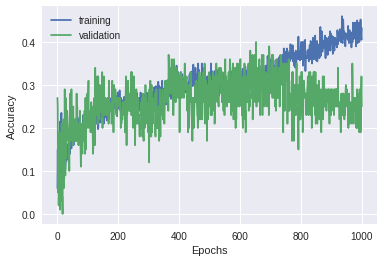

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
 
plt.plot(range(1, 1001), history.history['acc'], label="training")
plt.plot(range(1, 1001), history.history['val_acc'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()